In [ ]:
# To do this, we will need 
# i)  Two Dataloaders; MNIST, USPS
# ii) Four Networks;  LeNet-MNIST, LeNet-USPS
#iii) Train the four networks.
# iv) Make adv. samples.
# v)  Analyze them.

import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torch.utils as utils
from google.colab import drive
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

lr = 0.001

In [ ]:
# Define LeNet
class LeNet(nn.Module):
  def __init__(self, input_dim=1, num_class=10):
    super(LeNet, self).__init__()

    # Convolutional layers
    self.conv1 = nn.Conv2d(input_dim, 20,  kernel_size=5, stride=1, padding=0)
    self.conv2 = nn.Conv2d(    20,    50,  kernel_size=5, stride=1, padding=0)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    # Fully connected layers
    self.fc1 = nn.Linear(50, 500)
    self.fc2 = nn.Linear(500, num_class)
    
    # Activation func.
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))        # Conv.-> ReLU
    x = F.max_pool2d(x, kernel_size=2, stride=2)  # Pooling with 2x2 window
    x = self.relu(self.conv2(x))        # Conv.-> ReLU
    x = F.max_pool2d(x, kernel_size=2, stride=2)  # Pooling with 2x2 window

    x = self.avgpool(x)
    b,c,h,w = x.size()                  # batch, channels, height, width
    x = x.view(b, -1)                   # flatten the tensor x

    x = self.relu(self.fc1(x))          # fc-> ReLU
    x = self.fc2(x)                     # fc
    return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class _3C_2FC(nn.Module):
  def __init__(self, input_dim=1, num_class=10):
    super(_3C_2FC, self).__init__()

    self.conv1 = nn.Conv2d(input_dim, 20,  kernel_size=5, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(20)   
    #self.conv1_drop = nn.Dropout2d()
    self.conv2 = nn.Conv2d(    20,    50,  kernel_size=5, stride=1, padding=0)
    self.bn2 = nn.BatchNorm2d(50)    
    #self.conv2_drop = nn.Dropout2d()
    self.conv3 = nn.Conv2d(    50,    100,  kernel_size=3, stride=1, padding=0) 
    self.bn3 = nn.BatchNorm2d(100) 
    #self.conv3_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(100, 50)
    self.fc2 = nn.Linear(50, num_class)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))                                   # Conv.-> ReLU
    x = self.bn1(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)                  # Pooling with 2x2 window
    x = self.relu(self.conv2(x))                                  # Conv.-> ReLU
    x = self.bn2(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)                  # Pooling with 2x2 window
    x = self.relu(self.conv3(x))                                  # Conv.-> ReLU
    x = self.bn3(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)                  # Pooling with 2x2 window

    b,c,h,w = x.size()                                            # batch, channels, height, width
    x = x.view(b, -1)                                             # flatten the tensor x
    x = self.relu(self.fc1(x))                                    # fc-> ReLU
    x = self.fc2(x)                                               # fc
    return x

In [ ]:
# Make MINIST dataloaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./data', train=True,  download=True, transform=transform)
mnist_test  = datasets.MNIST('./data', train=False, download=True, transform=transform)
mnist_trainloader = utils.data.DataLoader(mnist_train, batch_size=50, shuffle=True,  num_workers=2)
mnist_testloader  = utils.data.DataLoader(mnist_test,  batch_size=1,  shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Make USPS dataloaders
transform = transforms.Compose([transforms.Resize(size=(28, 28), interpolation=Image.BICUBIC),transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
usps_train = datasets.USPS('./data', train=True,  download=True, transform=transform)
usps_test  = datasets.USPS('./data', train=False, download=True, transform=transform)
usps_trainloader = utils.data.DataLoader(usps_train, batch_size=50, shuffle=True,  num_workers=2)
usps_testloader  = utils.data.DataLoader(usps_test,  batch_size=1,  shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


  0%|          | 0/6579383 [00:00<?, ?it/s]

  0%|          | 0/1831726 [00:00<?, ?it/s]

In [ ]:
def plot_traininigloss(loss_rec, tag):
    plt.clf()
    plt.grid(linestyle='-')
    plt.plot(loss_rec)
    plt.title(tag+" training loss plot")
    plt.ylabel("Loss")
    plt.show()

In [ ]:
# Script for training a network
def train_model(net, optimizer, dataloader, loss_func, epoch_size=2, use_gpu=True):
    loss_rec    = []    # For plotting loss
    for epoch in range(epoch_size):
        running_loss = 0.0
        ct_num = 0
        for iteration, data in enumerate(dataloader):
            inputs, labels = data
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            outputs = net(inputs)
            loss    = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
        
            with torch.no_grad():
                running_loss+= loss.item()
                ct_num+= 1
                if iteration%10 == 9:
                    clear_output(wait=True)
                    print("Epoch ["+str(epoch+1)+"/"+str(epoch_size)+"], Iteration: "+str(iteration+1)+", Loss: "+str(running_loss/ct_num)+'.')
                    loss_rec.append(running_loss/ct_num)
    return loss_rec

In [ ]:
# Script for testing a network
def evaluate_model(net, dataloader, tag, Pretrained=None, resize_to=None):
    print("Testing the network...")
    if not Pretrained is None:
        net.load_state_dict(torch.load(Pretrained))
    net.eval()
    total_num   = 0
    correct_num = 0
    for test_iter, test_data in enumerate(dataloader):
        # Get one batch of test samples
        inputs, labels = test_data    
        if not resize_to is None:
            inputs = F.interpolate(inputs, size=resize_to, mode='bicubic')
        bch = inputs.size(0)

        # Move inputs and labels into GPU
        inputs = inputs.cuda()
        labels = torch.LongTensor(list(labels)).cuda()

        # Forward
        outputs = net(inputs)   

        # Get predicted classes
        _, pred_cls = torch.max(outputs, 1)
#        if total_num == 0:
#           print("True label:\n", labels)
#           print("Prediction:\n", pred_cls)
        # Record test resultplot_traininigloss
        correct_num+= (pred_cls == labels).float().sum().item()
        total_num+= bch
#    net.train()
    print(tag+"- accuracy: "+"%.2f"%(correct_num/float(total_num)))

Epoch [10/10], Iteration: 1200, Loss: 0.08805242798174731.
Testing the network...
lenet- accuracy: 0.98


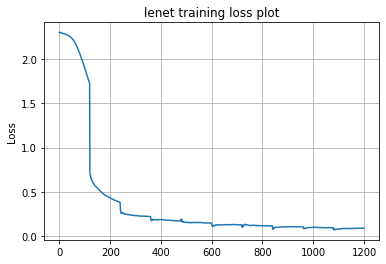

In [ ]:
# Train the two network on MNIST, save the trained models in Google Drive.
drive.mount('/content/gdrive/')
save_root = F"/content/gdrive/My Drive/"
save_pth_lenet   = save_root+'lenet_mnist.pt'
#save_pth_3c_2fc = save_root+'3C_2FC_mnist.pt'
lenet   = LeNet().cuda()
#_3c_2fc = _3C_2FC().cuda()
lenet_optimizer   = optim.SGD(lenet.parameters(),   lr=lr, momentum=0.9)
#_3c_2fc_optimizer = optim.SGD(_3c_2fc.parameters(), lr=lr, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

# Train lenet on MNIST.
lenet_loss_rec = train_model(lenet, lenet_optimizer, mnist_trainloader, loss_func, epoch_size=10, use_gpu=True)
torch.save(lenet.state_dict(), save_pth_lenet)

# Train 3c_2fc on MNIST
#_3c_2fc_loss_rec = train_model(_3c_2fc, _3c_2fc_optimizer, mnist_trainloader, loss_func, epoch_size=20, use_gpu=True)
#torch.save(_3c_2fc.state_dict(), save_pth_3c_2fc)

# Test them.
evaluate_model(lenet,   mnist_testloader, tag='lenet')
#evaluate_model(_3c_2fc, mnist_testloader, tag='3c_2fc')

# Plot figures
plot_traininigloss(lenet_loss_rec,   tag='lenet')
#plot_traininigloss(_3c_2fc_loss_rec, tag='3c_2fc')

Epoch [50/50], Iteration: 140, Loss: 0.1046789432809289.
Testing the network...
lenet- accuracy: 0.93


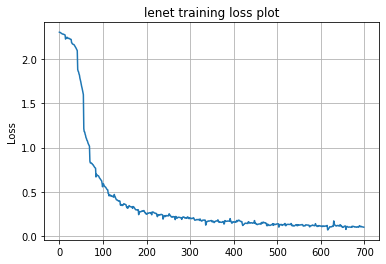

In [ ]:
# Train the two network on USPS, save the trained models in Google Drive.
drive.mount('/content/gdrive/')
save_root = F"/content/gdrive/My Drive/"
save_pth_lenet   = save_root+'lenet_usps.pt'
#save_pth_3c_2fc = save_root+'3C_2FC_usps.pt'
lenet   = LeNet().cuda()
#_3c_2fc = _3C_2FC().cuda()
lenet_optimizer   = optim.SGD(lenet.parameters(),   lr=lr, momentum=0.9)
#_3c_2fc_optimizer = optim.SGD(_3c_2fc.parameters(), lr=lr, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

# Train lenet on USPS.
lenet_loss_rec = train_model(lenet, lenet_optimizer, usps_trainloader, loss_func, epoch_size=50, use_gpu=True)
torch.save(lenet.state_dict(), save_pth_lenet)
# Train alexnet on USPS
#_3c_2fc_loss_rec = train_model(_3c_2fc, _3c_2fc_optimizer, usps_trainloader, loss_func, epoch_size=100, use_gpu=True)
#torch.save(_3c_2fc.state_dict(), save_pth_3c_2fc)
# Test them.
evaluate_model(lenet,   usps_testloader, tag='lenet')
#evaluate_model(_3c_2fc, usps_testloader, tag='3c_2fc')

#Plot figures
plot_traininigloss(lenet_loss_rec,   tag='lenet')
#plot_traininigloss(_3c_2fc_loss_rec, tag='3c_2fc')



In [ ]:
# FGSM attack code from pytorch tutorials.
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image
    

In [ ]:
# Attack a network, make sure batch_size = 1 for this block
def attack_model(net, dataloader, epsilon, Pretrained=None):
    if not Pretrained is None:
        net.load_state_dict(torch.load(Pretrained))
    correct = 0
    adv_samples   = []
    sample_labels = []
    for _, data in enumerate(dataloader):
        image, target = data
        image, target = image.cuda(), target.cuda()

        # Set requires_grad attribute of tensor.
        image.requires_grad = True

        # Forward pass the data through the model
        output = net(image)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        net.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        image_grad = image.grad.data

        # Call FGSM Attack
        perturbed_image = fgsm_attack(image, epsilon, image_grad)

        # Save perturbed_images
        adv_samples.append(perturbed_image.detach().cpu())
        sample_labels.append(target)

        # Re-classify the perturbed image
        output = net(perturbed_image)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1


    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(dataloader))
    print("Epsilon: {}\tTest Accuracy = {}".format(epsilon, final_acc))

    # Return the accuracy and an adversarial example
    return adv_samples, sample_labels

In [ ]:
# Attack LeNet
drive.mount('/content/gdrive/')
save_root = F"/content/gdrive/My Drive/"
lenet   = LeNet().cuda()
_3c_2fc = _3C_2FC().cuda()
Pretrained = save_root+'lenet_mnist.pt'
epsilon = 0.6  # epsilon is the pixel-wise perturbation amount. A Hyper-param
adv_samples, sample_labels = attack_model(lenet, mnist_testloader, epsilon=epsilon, Pretrained=Pretrained)

NameError: ignored

[tensor([9], device='cuda:0'), tensor([6], device='cuda:0'), tensor([3], device='cuda:0'), tensor([6], device='cuda:0'), tensor([6], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([6], device='cuda:0'), tensor([9], device='cuda:0')]


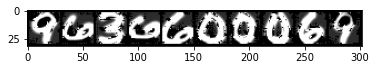

In [ ]:
show_imgs = torch.cat(adv_samples[:10], dim=0)
show_imgs = torchvision.utils.make_grid(show_imgs, nrow=10).numpy().transpose((1,2,0))
plt.imshow(show_imgs)
print(sample_labels[:10])

In [ ]:
# Attack AlexNet using LeNets' adv_samples.
Pretrained = save_root+'3C_2FC_usps.pt'
transform_norm = transforms.Normalize((0.1307,), (0.3081,))
dataloader = []
for i, target in enumerate(sample_labels):
    adv_sample = transform_norm(adv_samples[i][0])
    dataloader.append((adv_sample.unsqueeze(dim=0), target))
evaluate_model(_3c_2fc, dataloader, tag='..', Pretrained=Pretrained)


Testing the network...
..- accuracy: 0.25
